# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from lightgbm import LGBMRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [98]:
data = pd.read_csv("/datasets/autos.csv")

In [99]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Приведём столбцы с датой к формату datetime64.

In [101]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [102]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Посмотрим на целевой столбец Price с ценой автомобилей.

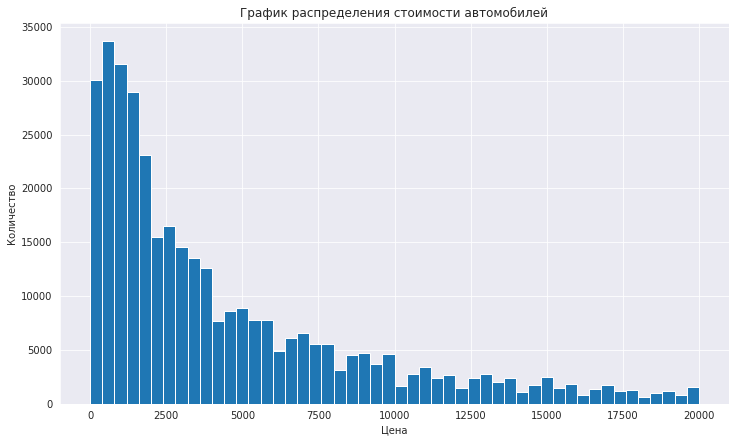

In [103]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

In [104]:
data.loc[data['Price'] < 10]['Price'].count()

12028

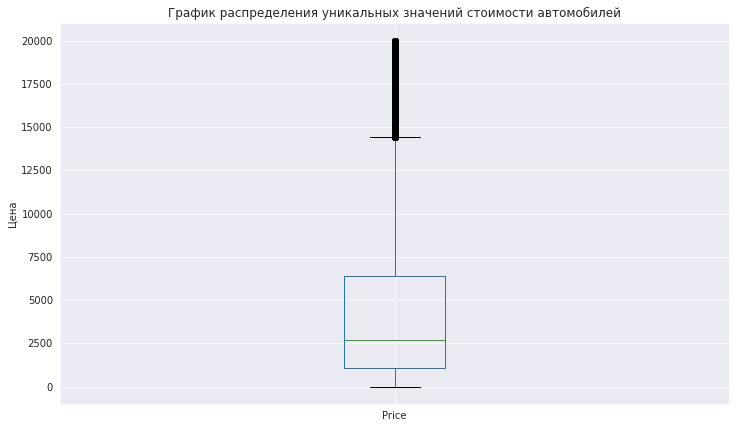

In [105]:
data.boxplot(['Price'],figsize = (12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')

plt.ylabel('Цена')
plt.show()

Удалим данные стоимости автомобилей ниже 10 усл.ед., т.к. такие значения нам не интересны. Владельцы а/м могут указывать такую цену только за разбитый а/м под восставновление, либо с расчётом на равноценный обмен.

In [106]:
data = data.query('Price> 10')

In [107]:
data.loc[data['Price'] < 10]['Price'].count()

0

### Посмотрим на отсутствующие значения колонки "VehicleType" и заполним их значением N/A.

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342257 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        342257 non-null  datetime64[ns]
 1   Price              342257 non-null  int64         
 2   VehicleType        309055 non-null  object        
 3   RegistrationYear   342257 non-null  int64         
 4   Gearbox            325355 non-null  object        
 5   Power              342257 non-null  int64         
 6   Model              325026 non-null  object        
 7   Kilometer          342257 non-null  int64         
 8   RegistrationMonth  342257 non-null  int64         
 9   FuelType           313315 non-null  object        
 10  Brand              342257 non-null  object        
 11  Repaired           277131 non-null  object        
 12  DateCreated        342257 non-null  datetime64[ns]
 13  NumberOfPictures   342257 non-null  int64   

In [109]:
data['VehicleType'] = data['VehicleType'].fillna('N/A')

И проверим на результат

In [110]:
data.VehicleType.isna().sum()

0

### Проверим столбец "RegistrationYear" на уникальные значения.

In [111]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

<AxesSubplot:ylabel='Frequency'>

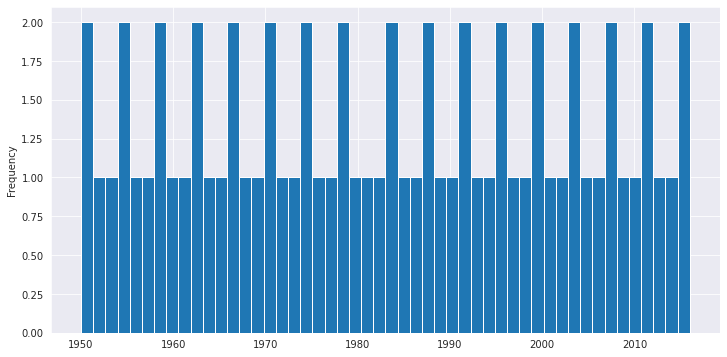

In [113]:
pd.Series(list(data.RegistrationYear.unique())).sort_values(ascending=False).plot(kind = 'hist', figsize = (12,6), grid = True, bins = 50, range=(1950,2016))

Вычислим дату формирования списков а/м и отсортируем данные о регистрации по этой дате, а так же удалим совсем старые а/м, которым более 67 лет.


In [17]:
data.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [18]:
data = data.query('RegistrationYear >= 1950 & RegistrationYear < 2017')

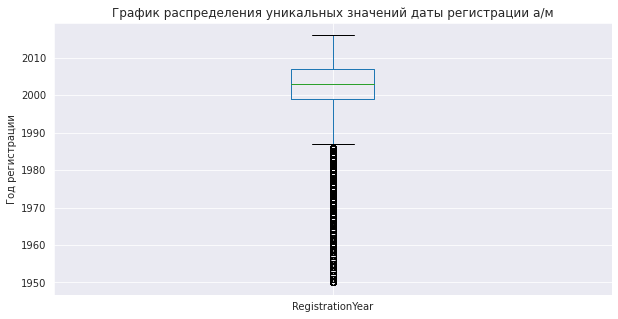

In [19]:
data.boxplot('RegistrationYear', figsize = (10,5))
plt.title('График распределения уникальных значений даты регистрации а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328385 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328385 non-null  datetime64[ns]
 1   Price              328385 non-null  int64         
 2   VehicleType        328385 non-null  object        
 3   RegistrationYear   328385 non-null  int64         
 4   Gearbox            313265 non-null  object        
 5   Power              328385 non-null  int64         
 6   Model              313070 non-null  object        
 7   Kilometer          328385 non-null  int64         
 8   RegistrationMonth  328385 non-null  int64         
 9   FuelType           304746 non-null  object        
 10  Brand              328385 non-null  object        
 11  Repaired           269271 non-null  object        
 12  DateCreated        328385 non-null  datetime64[ns]
 13  NumberOfPictures   328385 non-null  int64   

### Посмотрим на отсутствующие данные по столбцу "Gearbox".

In [21]:
data.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16,2016-04-01 12:46:46,300,N/A,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,N/A,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,N/A,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,N/A,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,N/A,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


Информация о корбкe передач достаточно важный параметр, который сильно может повлиять на модель при обучении. В связи с этим лучше избавиться от этих данных во избежании лишнего "шума", чем заполнить пропуски каким-то значением. К тому же по данным строкам есть множество ошибочных значений и пропусков в других столбцах.

In [22]:
data.dropna(subset = ['Gearbox'], inplace=True)

In [23]:
data.Gearbox.unique()

array(['manual', 'auto'], dtype=object)

### Посмотрим на значения в столбце "Power".

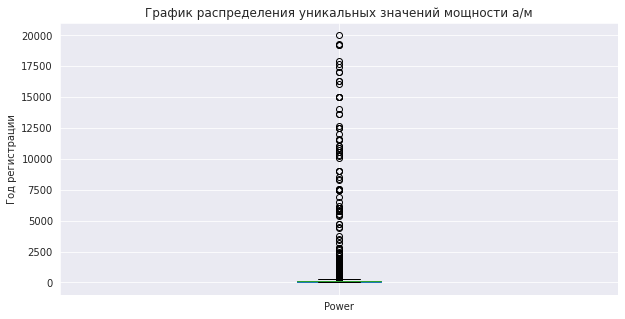

In [24]:
data.boxplot('Power', figsize = (10,5))
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

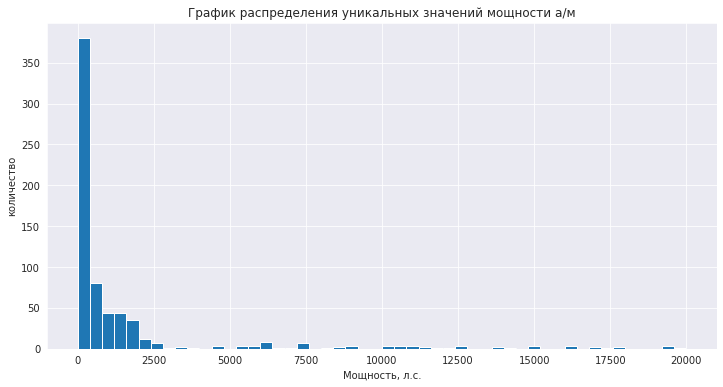

In [25]:
pd.Series(list(data.Power.unique())).sort_values(ascending = False).plot(kind = 'hist', figsize = (12,6), grid = True, bins = 50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

Очевидно, что таких мощностей не бывает и такие данные так же требуется удалить из нашей базы данных.

In [26]:
data.Power.describe()

count    313265.000000
mean        115.633425
std         184.833026
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64

In [27]:
data = data.query('Power > 15 & Power < 1001')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290279 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        290279 non-null  datetime64[ns]
 1   Price              290279 non-null  int64         
 2   VehicleType        290279 non-null  object        
 3   RegistrationYear   290279 non-null  int64         
 4   Gearbox            290279 non-null  object        
 5   Power              290279 non-null  int64         
 6   Model              280014 non-null  object        
 7   Kilometer          290279 non-null  int64         
 8   RegistrationMonth  290279 non-null  int64         
 9   FuelType           276108 non-null  object        
 10  Brand              290279 non-null  object        
 11  Repaired           250026 non-null  object        
 12  DateCreated        290279 non-null  datetime64[ns]
 13  NumberOfPictures   290279 non-null  int64   

### Просмотрим пропущенные значения по столбцу "Model".

In [29]:
data.query('Model.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,2016-03-21 08:36:18,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,2016-03-21,0,26382,2016-04-06 02:45:28
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25


Модель - это основопологающий фактор, который на прямую воздействует на образование цены и заменить его на что-либо другое будет неправильно, удалим отсутствующие значения из наших данных.

In [30]:
data.dropna(subset = ['Model'], inplace = True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        280014 non-null  datetime64[ns]
 1   Price              280014 non-null  int64         
 2   VehicleType        280014 non-null  object        
 3   RegistrationYear   280014 non-null  int64         
 4   Gearbox            280014 non-null  object        
 5   Power              280014 non-null  int64         
 6   Model              280014 non-null  object        
 7   Kilometer          280014 non-null  int64         
 8   RegistrationMonth  280014 non-null  int64         
 9   FuelType           268166 non-null  object        
 10  Brand              280014 non-null  object        
 11  Repaired           242994 non-null  object        
 12  DateCreated        280014 non-null  datetime64[ns]
 13  NumberOfPictures   280014 non-null  int64   

### Посмотрим на данные о пробеге а/м в столбце "Kilometer".

In [32]:
data.Kilometer.describe()

count    280014.000000
mean     128324.369496
std       36538.570047
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Данный столбец не требует изменений, здесь видно все в порядке. 

### Посмотрим на значения в столбце "RegistrationMonth".

In [33]:
data.RegistrationMonth.describe()

count    280014.000000
mean          6.054715
std           3.554072
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [34]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9])

In [35]:
data.RegistrationMonth.value_counts()

3     29181
6     26209
4     24552
5     24399
7     22658
10    21975
12    20244
11    20206
9     20114
1     19241
8     18828
2     17982
0     14425
Name: RegistrationMonth, dtype: int64

Т.к. этот параметр не имеет особого значения на ценообразование, а терять данные нам не хочется, заменим нулевые значения на среднее значение.

In [36]:
data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] = 6

И проверим результат.

In [37]:
data.loc[data['RegistrationMonth'] == 6].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,6,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
18,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11
31,2016-03-29 16:57:02,899,N/A,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,6,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09


In [38]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  5,  9])

### Посмотроим на значения в столбце "FuelType".

In [39]:
data.FuelType.unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [40]:
data.FuelType.value_counts()

petrol      178190
gasoline     84874
lpg           4357
cng            460
hybrid         178
other           69
electric        38
Name: FuelType, dtype: int64

In [41]:
data.FuelType.isna().sum()

11848

Заполним отсутствующие значения как "other".

In [42]:
data['FuelType'] = data['FuelType'].fillna('other')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        280014 non-null  datetime64[ns]
 1   Price              280014 non-null  int64         
 2   VehicleType        280014 non-null  object        
 3   RegistrationYear   280014 non-null  int64         
 4   Gearbox            280014 non-null  object        
 5   Power              280014 non-null  int64         
 6   Model              280014 non-null  object        
 7   Kilometer          280014 non-null  int64         
 8   RegistrationMonth  280014 non-null  int64         
 9   FuelType           280014 non-null  object        
 10  Brand              280014 non-null  object        
 11  Repaired           242994 non-null  object        
 12  DateCreated        280014 non-null  datetime64[ns]
 13  NumberOfPictures   280014 non-null  int64   

### Посмотроим на значения в столбце "Brand".

In [44]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Тут ничего дополнять или удалять не нужно, все в порядке. 

Посмотрим на значения в столбце "Repaired".

In [45]:
data.Repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [46]:
data.Repaired.isna().sum()

37020

Очевидно, что эти данные лучше заполнить N/A, чем потерять 39000 строк остального массива данных.

In [47]:
data['Repaired'] = data['Repaired'].fillna('N/A')

И проверим.

In [48]:
data.Repaired.unique()

array(['N/A', 'no', 'yes'], dtype=object)

### Посмотрим на значения в столбце "DateCreated".

In [49]:
data.DateCreated.describe()

count                  280014
unique                    105
top       2016-04-03 00:00:00
freq                    11054
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

### Посмотрим на значения в столбце "NumberOfPictures".

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        280014 non-null  datetime64[ns]
 1   Price              280014 non-null  int64         
 2   VehicleType        280014 non-null  object        
 3   RegistrationYear   280014 non-null  int64         
 4   Gearbox            280014 non-null  object        
 5   Power              280014 non-null  int64         
 6   Model              280014 non-null  object        
 7   Kilometer          280014 non-null  int64         
 8   RegistrationMonth  280014 non-null  int64         
 9   FuelType           280014 non-null  object        
 10  Brand              280014 non-null  object        
 11  Repaired           280014 non-null  object        
 12  DateCreated        280014 non-null  datetime64[ns]
 13  NumberOfPictures   280014 non-null  int64   

In [51]:
data.NumberOfPictures.describe()

count    280014.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

В данном столбце нет никакой пользы для обучения модели, т.к. кроме нулей здесь значений нет. Такой столбец лучше так же исключить из списка.

In [52]:
data = data.drop(['NumberOfPictures'], axis = 1)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        280014 non-null  datetime64[ns]
 1   Price              280014 non-null  int64         
 2   VehicleType        280014 non-null  object        
 3   RegistrationYear   280014 non-null  int64         
 4   Gearbox            280014 non-null  object        
 5   Power              280014 non-null  int64         
 6   Model              280014 non-null  object        
 7   Kilometer          280014 non-null  int64         
 8   RegistrationMonth  280014 non-null  int64         
 9   FuelType           280014 non-null  object        
 10  Brand              280014 non-null  object        
 11  Repaired           280014 non-null  object        
 12  DateCreated        280014 non-null  datetime64[ns]
 13  PostalCode         280014 non-null  int64   

### Посмотрим на значения в столбце "PostalCode".

In [54]:
data.PostalCode.describe()

count    280014.000000
mean      51341.244427
std       25778.490623
min        1067.000000
25%       30982.000000
50%       50374.000000
75%       72175.000000
max       99998.000000
Name: PostalCode, dtype: float64

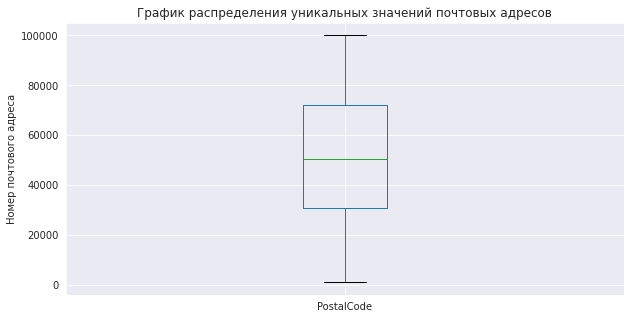

In [55]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

Распределение почтовых номеров говорит нам о том, что здесь нет необходимости что-либо корректировать, а сохранять такие данные следует только с целью вычисления географической принадлежности а/м. В нашем случае, чтобы избежать большого количества категорий оставим от индекса только первую цифру.

In [56]:
data["PostalCode"] = data["PostalCode"].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        280014 non-null  datetime64[ns]
 1   Price              280014 non-null  int64         
 2   VehicleType        280014 non-null  object        
 3   RegistrationYear   280014 non-null  int64         
 4   Gearbox            280014 non-null  object        
 5   Power              280014 non-null  int64         
 6   Model              280014 non-null  object        
 7   Kilometer          280014 non-null  int64         
 8   RegistrationMonth  280014 non-null  int64         
 9   FuelType           280014 non-null  object        
 10  Brand              280014 non-null  object        
 11  Repaired           280014 non-null  object        
 12  DateCreated        280014 non-null  datetime64[ns]
 13  PostalCode         280014 non-null  object  

In [57]:
first_index = []
for word in np.array(data['PostalCode']):
    case_word = word[0]
    first_index.append(case_word)
data["GeographyIndex"] = first_index
data["GeographyIndex"] = data["GeographyIndex"].astype('int')

In [58]:
data['PostalCode'].str[0]

2         9
3         9
4         6
5         3
6         6
         ..
354361    5
354362    9
354366    2
354367    8
354368    4
Name: PostalCode, Length: 280014, dtype: object

Провермим результат.

In [59]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeographyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9


### Посмотрим на значения в столбце "LastSeen".

In [60]:
data.LastSeen.describe()

count                  280014
unique                 147420
top       2016-04-07 13:17:48
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

### Посмотрим коррелирущие значения после предобработки данных.

In [61]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,GeographyIndex
Price,1.000000,0.517925,0.500538,-0.396305,0.014771,0.057785
RegistrationYear,0.517925,1.000000,0.139306,-0.326255,0.003600,0.022526
Power,0.500538,0.139306,1.000000,0.101926,0.021971,0.049788
Kilometer,-0.396305,-0.326255,0.101926,1.000000,0.003732,-0.016138
RegistrationMonth,0.014771,0.003600,0.021971,0.003732,1.000000,-0.007350
GeographyIndex,0.057785,0.022526,0.049788,-0.016138,-0.007350,1.000000


Наблюдается сильная положительная корреляция стоимости от мощности и года регитстрации а/м, в то время как пробег имеет сильную отрицательную зависмость и так же сказывается на ценообразовании подержанного автомобиля.

### Просмотим зависимость целевого значения от других признаков в наших данных на графике.

In [62]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen', 'GeographyIndex'],
      dtype='object')

In [63]:
column=['Price', 'RegistrationYear',
       'Power', 'Kilometer','FuelType']

In [64]:
data_graph = data[column]
data_graph[:5]

,Price,RegistrationYear,Power,Kilometer,FuelType
2,9800,2004,163,125000,gasoline
3,1500,2001,75,150000,petrol
4,3600,2008,69,90000,gasoline
5,650,1995,102,150000,petrol
6,2200,2004,109,150000,petrol


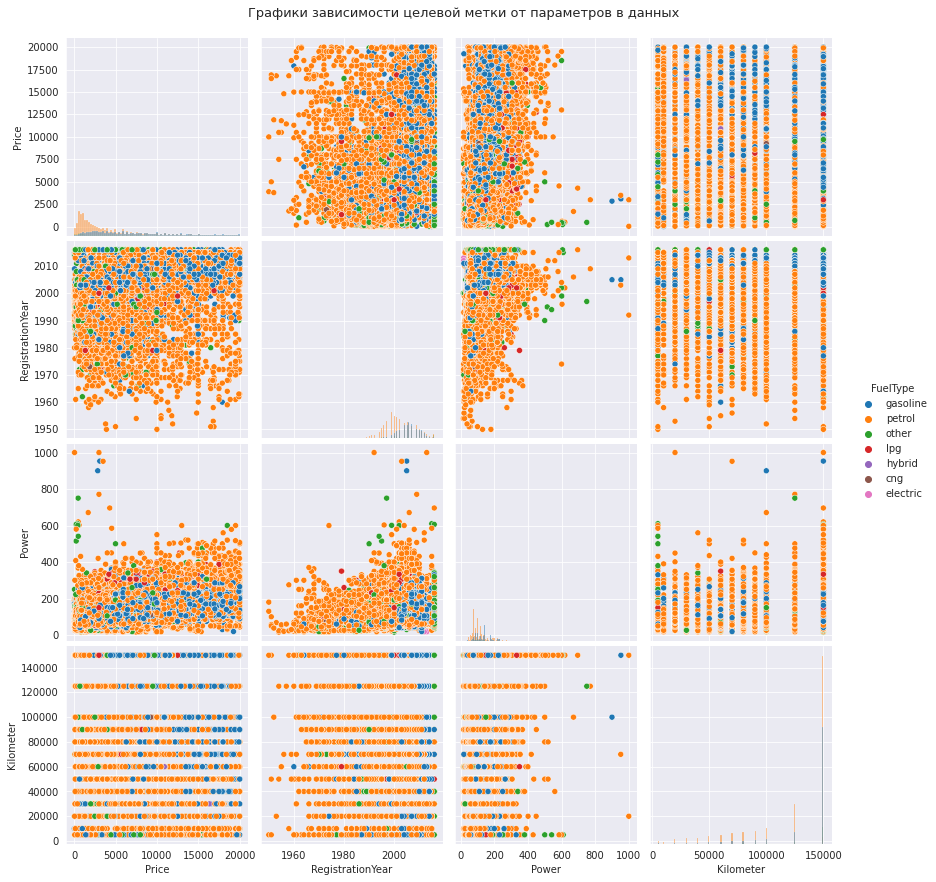

In [65]:
sns.pairplot(data_graph[:100000], hue='FuelType', height=3, diag_kind='hist')
plt.suptitle("Графики зависимости целевой метки от параметров в данных", y=1.02, fontsize=13)
plt.show()

<AxesSubplot:xlabel='RegistrationYear'>

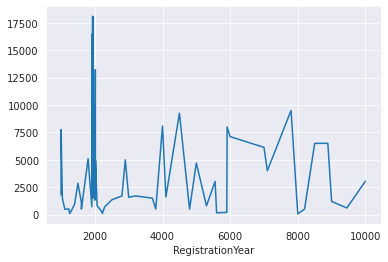

In [114]:
data[['Price', 'RegistrationYear']].groupby('RegistrationYear')['Price'].mean().plot()

Судя по графику можно сказать, что начиная с 1980 года стоимосоть а/м увеличивается с каждым годом и имеет линейную зависимость, при этом не важен тип используемого топлива. Так же из графиков хорошо видно, что альтернативные виды топлива начали активно использоваться в автомобилях начиная с 2000 годов в то время как бензиновые двигателя начали отходить на второй план.

Как мы видим на графике, с 2000 года возросла стоимость автомобиля. А в 2015 году средняя цена 13000. 

### Применим кодирование текстовых данных в категориальные цифровые значения методом OrdinalEncoder. 

Для начала выберем действительно значимые столбцы, которые могут иметьзначения в ценообразовании стоимости подержанных автомоблилей, а лишние значения мы опустим, чтобы не "зашумлять" вычисления моделей.

In [67]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeographyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9


In [68]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen', 'GeographyIndex'],
      dtype='object')

In [69]:
columns = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
           'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
           'Repaired','GeographyIndex']

### Запишем данные с интересующими нас столбцами в новую df.

In [70]:
data_new = data[columns].copy()
data_new.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeographyIndex
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9


In [71]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              280014 non-null  int64 
 1   VehicleType        280014 non-null  object
 2   RegistrationYear   280014 non-null  int64 
 3   Gearbox            280014 non-null  object
 4   Power              280014 non-null  int64 
 5   Model              280014 non-null  object
 6   Kilometer          280014 non-null  int64 
 7   RegistrationMonth  280014 non-null  int64 
 8   FuelType           280014 non-null  object
 9   Brand              280014 non-null  object
 10  Repaired           280014 non-null  object
 11  GeographyIndex     280014 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 27.8+ MB


In [72]:
data_new.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
GeographyIndex       0
dtype: int64

### Проведем замену столбцов Gearbox и Repaired на булев тип.

IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
IsRepaired. 1(yes) - означает машину с ремонтом. 0(no) - без ремонта.

In [73]:
data_new['IsManualGearbox'] = 0
data_new.loc[data_new['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(data_new['IsManualGearbox'].value_counts())
data_new['Gearbox'].value_counts()

1    223514
0     56500
Name: IsManualGearbox, dtype: int64

manual    223514
auto       56500
Name: Gearbox, dtype: int64

In [74]:
data_new['IsRepaired'] = 0
data_new.loc[data_new['Repaired'] == 'no', 'IsRepaired'] = 0
display(data_new['IsRepaired'].value_counts())
data_new['Repaired'].value_counts()

0    280014
Name: IsRepaired, dtype: int64

no     216215
N/A     37020
yes     26779
Name: Repaired, dtype: int64

Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с датой.

In [75]:
data_new.drop(['Repaired','Gearbox'], inplace=True, axis=1)
data_new['IsRepaired'] = pd.to_numeric(data_new['IsRepaired'], downcast='integer')
data_new['IsManualGearbox'] = pd.to_numeric(data_new['IsManualGearbox'], downcast='integer')
data_new['RegistrationYear'] = pd.to_numeric(data_new['RegistrationYear'], downcast='integer')
data_new['Power'] = pd.to_numeric(data_new['Power'], downcast='integer')
data_new['Kilometer'] = pd.to_numeric(data_new['Kilometer'], downcast='integer')
data_new['Price'] = pd.to_numeric(data_new['Price'], downcast='integer')
data_new.info()
display(data_new.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280014 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              280014 non-null  int16 
 1   VehicleType        280014 non-null  object
 2   RegistrationYear   280014 non-null  int16 
 3   Power              280014 non-null  int16 
 4   Model              280014 non-null  object
 5   Kilometer          280014 non-null  int32 
 6   RegistrationMonth  280014 non-null  int64 
 7   FuelType           280014 non-null  object
 8   Brand              280014 non-null  object
 9   GeographyIndex     280014 non-null  int64 
 10  IsManualGearbox    280014 non-null  int8  
 11  IsRepaired         280014 non-null  int8  
dtypes: int16(3), int32(1), int64(2), int8(2), object(4)
memory usage: 18.2+ MB


(280014, 12)

### Сбросим индексы, после удаления лишних значений.

In [76]:
data_new = data_new.reset_index(drop=True)

In [77]:
data_new

,Price,VehicleType,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,GeographyIndex,IsManualGearbox,IsRepaired
0,9800,suv,2004,163,grand,125000,8,gasoline,jeep,9,0,0
1,1500,small,2001,75,golf,150000,6,petrol,volkswagen,9,1,0
2,3600,small,2008,69,fabia,90000,7,gasoline,skoda,6,1,0
3,650,sedan,1995,102,3er,150000,10,petrol,bmw,3,1,0
4,2200,convertible,2004,109,2_reihe,150000,8,petrol,peugeot,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
280009,5250,N/A,2016,150,159,150000,12,other,alfa_romeo,5,0,0
280010,3200,sedan,2004,225,leon,150000,5,petrol,seat,9,1,0
280011,1199,convertible,2000,101,fortwo,125000,3,petrol,smart,2,0,0
280012,9200,bus,1996,102,transporter,150000,3,gasoline,volkswagen,8,1,0


<b>ВЫВОД</b>

Из даных убрали лишние и "битые" значения, трансформировали текстовые признаки в цифровой формат. Теперь перейдём к обучению моделей и выбору лучшей. А так же оценим их качество предсказания и скорость обучения.

## Обучение моделей

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

In [78]:
feat_train, feat_test, target_train, target_test = train_test_split(
    data_new.drop(columns=['Price']), data_new['Price'], test_size=0.25, random_state=12345)

In [79]:
enc_cols = ['VehicleType', 'FuelType', 'Brand', 'Model', 'GeographyIndex', 'RegistrationMonth']
num_cols = ['RegistrationYear', 'Power', 'Kilometer', ]
#X, y = data_new[enc_cols + num_cols], data_new['Price']
#feat_train, feat_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=12345)


ct = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), enc_cols), 
    (StandardScaler(), num_cols), remainder='passthrough'
)

### LinearRegression

In [80]:
model_lr_pipe = Pipeline(steps=[('prep', ct), ('reg', LinearRegression())])

In [81]:
gs_lr = GridSearchCV(model_lr_pipe, {'reg__fit_intercept':[True, False]}, scoring='neg_mean_squared_error')
gs_lr.fit(feat_train, target_train)


pd.DataFrame(gs_lr.cv_results_).iloc[gs_lr.best_index_]['mean_fit_time'], \
pd.DataFrame(gs_lr.cv_results_).iloc[gs_lr.best_index_]['mean_score_time'],\
(gs_lr.best_score_*(-1))**0.5

(0.3885232925415039, 0.15998215675354005, 2989.5746184398345)

# ------

### RandomForestRegressor

In [82]:
model_rfr_pipe = Pipeline(steps=[('prep', ct), ('reg', RandomForestRegressor())])

In [83]:
gs_rfr = GridSearchCV(model_rfr_pipe, {'reg__max_depth':[3], 'reg__n_estimators':[50]}, scoring='neg_mean_squared_error')
gs_rfr.fit(feat_train, target_train)

pd.DataFrame(gs_rfr.cv_results_).iloc[gs_rfr.best_index_]['mean_fit_time'], \
pd.DataFrame(gs_rfr.cv_results_).iloc[gs_rfr.best_index_]['mean_score_time'],\
(gs_rfr.best_score_*(-1))**0.5

(5.18622407913208, 0.10069637298583985, 2881.8197124588874)

### CatBoostRegressor

In [84]:
model_cbr_pipe = Pipeline(steps=[('prep', ct), ('reg', CatBoostRegressor())])

In [85]:
gs_cbr = GridSearchCV(model_cbr_pipe, {'reg__learning_rate':np.linspace(0.1, 0.5, 1)}, scoring='neg_mean_squared_error')
gs_cbr.fit(feat_train, target_train)

pd.DataFrame(gs_cbr.cv_results_).iloc[gs_cbr.best_index_]['mean_fit_time'], \
pd.DataFrame(gs_cbr.cv_results_).iloc[gs_cbr.best_index_]['mean_score_time'],\
(gs_cbr.best_score_*(-1))**0.5

0:	learn: 4323.7824812	total: 73.7ms	remaining: 1m 13s
1:	learn: 4053.5335768	total: 95.1ms	remaining: 47.5s
2:	learn: 3810.2323430	total: 118ms	remaining: 39.1s
3:	learn: 3593.2507917	total: 139ms	remaining: 34.6s
4:	learn: 3412.7553606	total: 161ms	remaining: 32s
5:	learn: 3250.3246130	total: 183ms	remaining: 30.3s
6:	learn: 3106.6479865	total: 205ms	remaining: 29s
7:	learn: 2981.9941025	total: 227ms	remaining: 28.2s
8:	learn: 2866.8966061	total: 248ms	remaining: 27.3s
9:	learn: 2772.3315682	total: 269ms	remaining: 26.7s
10:	learn: 2684.4382720	total: 289ms	remaining: 26s
11:	learn: 2611.4583764	total: 310ms	remaining: 25.5s
12:	learn: 2547.0594798	total: 336ms	remaining: 25.5s
13:	learn: 2488.5150767	total: 358ms	remaining: 25.2s
14:	learn: 2439.1395797	total: 378ms	remaining: 24.8s
15:	learn: 2394.9696605	total: 399ms	remaining: 24.6s
16:	learn: 2354.2651222	total: 425ms	remaining: 24.6s
17:	learn: 2318.9053173	total: 447ms	remaining: 24.4s
18:	learn: 2287.0216944	total: 467ms	rema

(23.457918643951416, 0.17207551002502441, 1615.6314833189517)

### LGBMRegressor

In [115]:
model_lgbm_pipe = Pipeline(steps=[('prep', ct), ('reg', LGBMRegressor())])

In [122]:
gs_lgbm = GridSearchCV(model_lgbm_pipe, 
                       {'reg__num_leaves':[31, 10], 
                        'reg__learning_rate':[0.5, 1],
                        'reg__num_threads':[2]},
                       scoring='neg_mean_squared_error')
gs_lgbm.fit(feat_train, target_train)

pd.DataFrame(gs_lgbm.cv_results_).iloc[gs_lgbm.best_index_]['mean_fit_time'], \
pd.DataFrame(gs_lgbm.cv_results_).iloc[gs_lgbm.best_index_]['mean_score_time'],\
(gs_lgbm.best_score_*(-1))**0.5

[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM]

(1.2515310764312744, 0.23685874938964843, 1646.0837204631534)

<b>Вывод</b>

По качеству предсказания на метрике MAE и распределению значений на графиках лучше всех себя показала модель RandomForestRegressor, а на метрике RMSE лучший результат у модели CatBoostRegressor. Модель LinearRegression оказаласть совсем не точной.

## Анализ моделей

Проанализируем скорость работы и качество моделей.

Для наглядности сведём все интересующие нас даные в таблицу.

In [88]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[(gs_lr.best_score_*(-1))**0.5,
                            (gs_rfr.best_score_*(-1))**0.5,
                            (gs_cbr.best_score_*(-1))**0.5,
                            (gs_lgbm.best_score_*(-1))**0.5],
        'Время обучения на CV, сек':[pd.DataFrame(gs_lr.cv_results_).iloc[gs_lr.best_index_]['mean_fit_time'],
                                     pd.DataFrame(gs_rfr.cv_results_).iloc[gs_rfr.best_index_]['mean_fit_time'],
                                     pd.DataFrame(gs_cbr.cv_results_).iloc[gs_cbr.best_index_]['mean_fit_time'],
                                     pd.DataFrame(gs_lgbm.cv_results_).iloc[gs_lgbm.best_index_]['mean_fit_time']],
        'Время предсказания модели, сек':[pd.DataFrame(gs_lr.cv_results_).iloc[gs_lr.best_index_]['mean_score_time'],
                                          pd.DataFrame(gs_rfr.cv_results_).iloc[gs_rfr.best_index_]['mean_score_time'],
                                          pd.DataFrame(gs_cbr.cv_results_).iloc[gs_cbr.best_index_]['mean_score_time'],
                                          pd.DataFrame(gs_lgbm.cv_results_).iloc[gs_lgbm.best_index_]['mean_score_time']]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Общее время, сек'] = (scores_data['Время обучения на CV, сек'] + scores_data['Время предсказания модели, сек'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","Время предсказания модели, сек","Общее время, сек"
LinearRegression,2989.574618,0.388523,0.159982,0.548505
RandomForestRegressor,2881.819712,5.186224,0.100696,5.286920
CatBoostRegressor,1615.631483,23.457919,0.172076,23.629994
LGBMRegressor,1646.083720,3.155382,0.301648,3.457030


Как мы видим на таблице, лучшая модель по метрике RMSE у CatBoostRegressor с 1615. Чуть хуже у LGBMRegressor, но и время обучение почти в 8 раз больше, чем у CatBoostRegressor. Хуже всех показала модель LinearRegressor, но зато обучение самое быстрое.

Теперь протестируем лучшую модель CatBoostRegressor.

In [123]:
%%time

gs_cbr = GridSearchCV(model_cbr_pipe, {'reg__learning_rate':np.linspace(0.1, 0.5, 1)}, scoring='neg_mean_squared_error')
gs_cbr.fit(feat_test, target_test)

pd.DataFrame(gs_cbr.cv_results_).iloc[gs_cbr.best_index_]['mean_fit_time'], \
pd.DataFrame(gs_cbr.cv_results_).iloc[gs_cbr.best_index_]['mean_score_time'],\
(gs_cbr.best_score_*(-1))**0.5

0:	learn: 4342.8226722	total: 7.73ms	remaining: 7.72s
1:	learn: 4077.7703156	total: 16.2ms	remaining: 8.06s
2:	learn: 3845.2155541	total: 27.5ms	remaining: 9.12s
3:	learn: 3637.5268293	total: 35.4ms	remaining: 8.81s
4:	learn: 3449.6679326	total: 43ms	remaining: 8.56s
5:	learn: 3286.2313197	total: 50.4ms	remaining: 8.35s
6:	learn: 3139.4323622	total: 58ms	remaining: 8.22s
7:	learn: 3011.0717033	total: 65.8ms	remaining: 8.15s
8:	learn: 2899.6086953	total: 73.4ms	remaining: 8.08s
9:	learn: 2804.1415214	total: 80.5ms	remaining: 7.97s
10:	learn: 2718.3851001	total: 88.1ms	remaining: 7.92s
11:	learn: 2645.7525062	total: 95.8ms	remaining: 7.89s
12:	learn: 2579.8952222	total: 103ms	remaining: 7.85s
13:	learn: 2526.5163396	total: 111ms	remaining: 7.8s
14:	learn: 2478.3891805	total: 118ms	remaining: 7.75s
15:	learn: 2431.6521558	total: 125ms	remaining: 7.71s
16:	learn: 2392.8893790	total: 133ms	remaining: 7.67s
17:	learn: 2357.5066678	total: 140ms	remaining: 7.66s
18:	learn: 2324.5335277	total: 

(9.106579780578613, 0.06934189796447754, 1676.2467404193526)

Построим график важности для лучшей выбранной модели

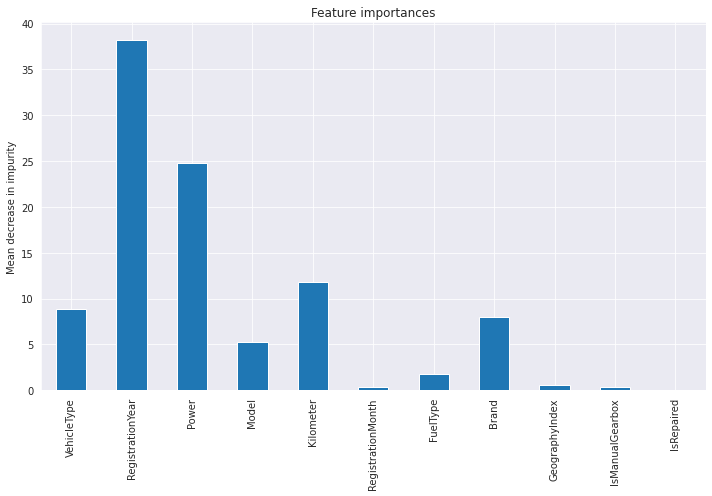

In [124]:
feature_names = feat_train.columns 
model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model'])
model.fit(feat_train, target_train)
pred = model.predict(feat_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

График важности модели соответствует тому, что было проанализировано в самом начале на исходных данных.

<b>Вывод</b>

В ходе работы было выполнено:

- Загружены данные. Проведен анализ и предобработка.
- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
- Выбрана лучшая модель по результатам метрики RMSE и времени обучения и это CatBoostRegressor.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей